#  Spectrum of the Lyman-n forest.

Data: The input data are files each representing a skewer through a 25Mpc co-moving simulation box.

I am going to add the Lyman-n series to each skewer then, eventually, add $\sim50$ skewers together to get a simulated quasar spectrum. 


In [1]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import matplotlib as mpl
from glob import glob
import numpy as np
import astropy.constants as const
import astropy.units as u
plt.rc('font', family='serif', size=15)

# path to the data, for both computers its in ~/Data:
path = '/Users/mwilde/Data/'

#use the pretty LaTeX fonts
mpl.rcParams.update({'text.usetex': True})

#### define constants:

In [2]:
# c = const.c.cgs.value # speed of light in cm/s
c = const.c.to(u.km / u.s).value # km/s
R_h = const.Ryd.to(1 / u.Angstrom).value # Rydberg constant in 1 /angstroms

#### Flux: 
$F = e^{-\tau}$ 

In [3]:
def flux(t):
    """A function to convert tau to flux using the relation
    
    I = I(0)exp(-tau)
    
    or if S_v = 1
    
    I = I(0)exp(-tau) + (1 - exp(-tau))
    with I(0) = 0.
    
    """
    return np.exp(-t)

#### Oscillator strength or $g-f$ value for the Lyman series: 
$gf_{1n} = \frac{2^9 n^5(n-1)^{2n-4}}{3(n+1)^{2n+4}}$

In [4]:
def gf_1n(nn):
    """ A function to calculate the oscillator strengths of of the Lyman series (n'=1).
        
        Reference: RL equation 10.45 (p.281)
    """
    if nn == 1:
        gf = 1.0
    elif nn == 0:
        gf = 1.0
    else:
        gf = (2**9 * nn**5 * (nn-1)**(2*nn-4)) / (3*(nn+1)**(2*nn+4))
    return gf

#### Convert velocity, $v$ into observed wavelength:
$\lambda_{obs}(1+z) = \lambda_0(1 - \frac{v}{c})$


In [5]:
def lam_obs(vv,lam_0):
    """This function takes as input the velocity in km/s and the emitted wavelength 
    as well as the redshift.
    
    returns the wavelength in the observers frame angstroms."""
    return lam_0*(1 - vv/c) # vv from km/s, c in km/s

#### Open the first few files:

Format of the data

velocity [km/s], tau_HILya, tau_HeI584, tau_HeIILya, nHI [cm^-3], nHeII [cm^-3], Delta_b, T [K], xpos [Mpc/h], vpec [km/sec]

In [10]:
infile = path+'sim_data/z2.45/spec_xHeII1_015_mt_line0000.dat'
v, tau_HILya, tau_HeI584, tau_HeIILya, nHI, nHeII, Delta_b, T, xpos, vpec = np.loadtxt(infile,unpack=True)

In [11]:
infile2 = path+'sim_data/z2.45/spec_xHeII1_015_mt_line0001.dat'
v2, tau_HILya_2, tau_HeI584, tau_HeIILya, nHI, nHeII, Delta_b, T, xpos, vpec = np.loadtxt(infile2,unpack=True)

In [12]:
infile3 = path+'sim_data/z2.45/spec_xHeII1_015_mt_line0002.dat'
v3, tau_HILya_3, tau_HeI584, tau_HeIILya, nHI, nHeII, Delta_b, T, xpos, vpec = np.loadtxt(infile3,unpack=True)

#### What does the data look like?

-10.2701449547


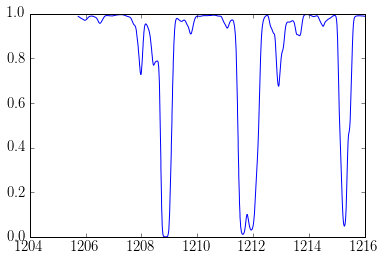

In [13]:
# plt.plot(v,tau_HILya)
plt.plot(lam_obs(v,1216), flux(tau_HILya_2))

print lam_obs(v,1216).min() - lam_obs(v,1216).max()

#### Add the Lyman series lines for first skewer.

$\tau_{1n} \rightarrow \frac{f_n}{f_{Ly\alpha}} \tau$ and $f_{Ly\alpha} = gf_{12}$ where $gf_{12}$ is the oscillator strength for the $n = 1$ to $n = 2$ transition. 

take the $\tau_{Ly\alpha}$ from the file and make a new array with added levels:

In [14]:
f_Lya = gf_1n(2) # define a variable for Lyman alpha oscillator strength
f_1n = np.array([gf_1n(n)/f_Lya for n in range(2,10000)]) # make an array of the oscillator strengths and convert to opacity
print f_1n

[  1.00000000e+00   1.90058112e-01   6.96570348e-02 ...,   3.75866022e-12
   3.75753250e-12   3.75640524e-12]


#### Get emitted wavelengths:


$ \frac{1}{\lambda} = Ry(1-\frac{1}{n^2})$

In [15]:
def lyman_lambda(nmax):
    return (R_h*(1 - (1/nmax**2)))**-1

#### Make a plot of the Lyman-n series for one skewer. 

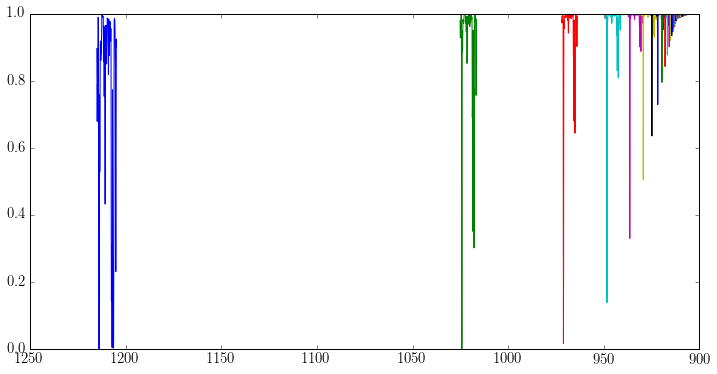

In [16]:
plt.figure(figsize=(12,6))
plt.gca().invert_xaxis()
v = velocity

for i in range(2,100):
    plt.plot(lam_obs(v,lyman_lambda(i)), flux(tau_HILya*f_1n[i-2]))

## Add more cells.

#### read in $n$ files. 

Each cell is added to the plot with $\lambda_{obs}(1+z) = \lambda_0(1 + \frac{v_1+v_2+...+v_n}{c})$

#### Read in $n$ files and populate $v$ and $\tau$ lists

In [17]:
v_list = []
t_list = []
file_list = glob(path+'sim_data/z2.45/spec_xHeII1_015_mt_line00*.dat')
for i,f in enumerate(file_list):
    v,t,c1,c2,c3,c4,c5,c6,c7,c8 = np.loadtxt(f, unpack=True)
    diffv = v[1] - v[0]
    v = np.arange(len(v))*diffv
    v_list.append(v)
    t_list.append(t)

#### Plot the forest

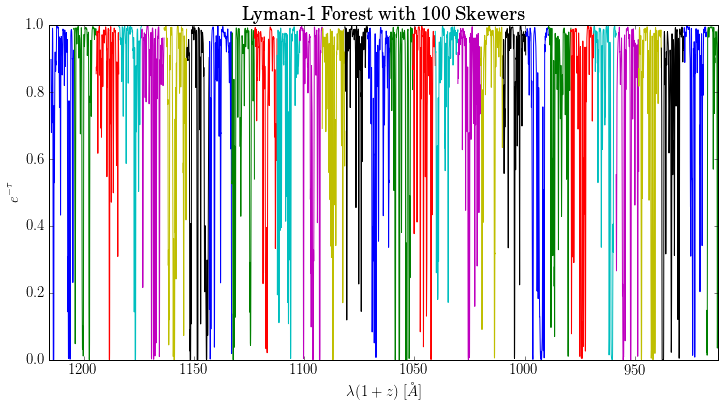

In [18]:
nskewers = len(file_list)
nlines = 1

plt.figure(figsize=(12,6))


# rearrange v_list to be sequential
for i in range(len(v_list)-1):
    v_list[i+1] = v_list[i].max() + v_list[0] + np.diff(v)[0]
    
    
tau_list = []
for i in range(2,nlines+2):
    for j in range(len(v_list)):
        #plt.plot(lyman_lambda(i)*(1 - v_list[j]/c), flux(t_list[j]*f_1n[i-2]))
        tau_list.append(t_list[j]*f_1n[i-2])
        
        plt.plot(lyman_lambda(i)*(1 - v_list[j]/c), flux(t_list[j]*f_1n[i-2]))

plt.title(r'Lyman-{} Forest with {} Skewers'.format(nlines,nskewers))
plt.xlabel(r'$\lambda(1+z)$ $[\AA]$')
plt.ylabel(r'$e^{-\tau}$')
plt.xlim(1216,912)
plt.show()

#### Find where in the v array the Lyman-$\beta$ series starts

In [19]:
lambda_alpha = lyman_lambda(2)
lambda_beta = lyman_lambda(3)
delta_v_ab = c*np.log(lambda_alpha[0]/lambda_beta[0])
Nb = np.where(abs(v_flat - delta_v_ab)/np.diff(v)[0] < 0.5)[0][0]



TypeError: 'float' object has no attribute '__getitem__'

#### Flatten the list of arrays and find where to add the Lyman-$\beta$ opacity. 

In [ ]:
v_flat = np.array(v_list).flatten()
tau_flat = np.array(tau_list).flatten()

tau_alpha = tau_flat.copy()
tau_alpha[Nb:] += tau_flat[:len(tau_alpha[Nb:])]*f_1n[1]


fig, ax = plt.subplots(figsize=(12,6))
ax.plot(v_flat, tau_flat)
ax.plot(v_flat, tau_alpha)

plt.show()

#### Now do it for the Lyman-$n$ series

In [ ]:
v_flat = np.array(v_list).flatten()
tau_flat = np.array(tau_list).flatten()

tau_n = tau_flat.copy()

lambda_alpha = lyman_lambda(2)

print "index","wavlength (A)"
for n in range(3,50):
    # find the index where the line starts in v
    lambda_n = lyman_lambda(n)
    delta_v_an = c*np.log(lambda_alpha/lambda_n) # km/s
    N_n = np.where(abs(v_flat - delta_v_an)/np.diff(v)[0] < 0.5)[0][0]
    
    print N_n, lambda_n[0]
    
    # sum the opacites at the point in the velocity array where they occur
    tau_n[N_n:] +=  tau_flat[:len(tau_n[N_n:])]*f_1n[n-2]

In [ ]:
print lambda_alpha
print lyman_lambda(2)*(1 - v/c)

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(v_flat, tau_n,label='Lyman-n')
ax.plot(v_flat, tau_alpha,label='Lyman-a+b')
ax.plot(v_flat, tau_flat,label='Lyman-a')
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(lam_obs(v_flat,lambda_n[0]), flux(tau_n)) # , color='black')
#ax.plot(lam_obs(v_flat,lambda_n[0]), flux(tau_alpha))
#ax.plot(lam_obs(v_flat,lambda_n[0]), flux(tau_flat))
ax.set_xlim(1216,912)
ax.set_xlabel(r'$\lambda(1+z)$ $[\AA]$')
ax.set_ylabel(r'$e^{-\tau}$')

plt.show()

# Make an average forest for 2000 different forests of length = 50

### Each box is then 1.25 Gpc/h

In [ ]:
box_size = 2.50e+04*u.kpc # [kpc/h]
num_boxes = 50
print (box_size*num_boxes).to(u.Gpc)

Read in each file and make an list of the $\tau_{HILy\alpha}$ arrays from each file:

In [ ]:
t_list = []
file_list = glob(path+'sim_data/z2.45/spec_xHeII1_015_mt_line*.dat')
for i,f in enumerate(file_list):
    v,t,c1,c2,c3,c4,c5,c6,c7,c8 = np.loadtxt(f, unpack=True)
    t_list.append(t)
diffv = v[1] - v[0]

This bit is a bit more complicated. I produce a list of arrays of opacities with differing numbers of lyman lines.

I have tried to vectorize with N_n being an array but it seems to fail.
    
    tau_n[N_n:] +=  tau_flat[:len(tau_n[N_n:])]*f_1n[n-2]



In [ ]:
diff_line_list = []

# make a velocity array with the correspoding length and delta v
v_flat = np.arange(0,3000*num_boxes)*diffv

# determine the wavelength of Lyman alpha line:
lambda_alpha = lyman_lambda(2)

# choose num_boxes different files and get their opacity
t_list = np.array(t_list)

for num_lines in [50,100,1000]:
    tau_final = []
    num_spectra = len(file_list)
    for i in range(num_spectra):

        # choose 50 random boxes from the 2000 different boxes
        t_sublist = t_list[np.random.randint(len(file_list), size=num_boxes),:]

        # flatten the array of opacity
        tau_flat = np.array(t_sublist).flatten()

        # make a deep copy of the flattened opacity array so it doesnt get changed below
        # when we +=
        tau_n = tau_flat.copy()

        # loop through the lyman series
        for n in range(3,num_lines):
            # find the wavelength where the line starts in v
            lambda_n = lyman_lambda(n)
            
            #determine the delta v between the Lyman-a and Lyman-n lines:
            delta_v_an = c*np.log(lambda_alpha/lambda_n) # km/s
            
            # determine what index the nth line should appear in the v_flat array
            N_n = np.where(abs(v_flat - delta_v_an)/diffv < 0.5)[0][0]

            # sum the opacites at the point in the velocity array where they occur
            # f_1n[1] = Lyman beta line
            tau_n[N_n:] +=  tau_flat[:len(tau_n[N_n:])]*f_1n[n-2]

        tau_final.append(tau_n)
    tau_final = np.array(tau_final)
    tau_final = tau_final.sum(0)
    diff_line_list.append(tau_final/num_spectra)

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(v_flat, diff_line_list[1], label='100 lines')
ax.plot(v_flat, diff_line_list[2], label='1000 lines')
ax.plot(v_flat, diff_line_list[0], label='50 lines')
#ax.plot(v_flat, tau_flat)
ax.legend()
plt.show()

In [ ]:

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(lam_obs(v_flat,1216), flux(diff_line_list[1]),label='100 lines') 
ax.plot(lam_obs(v_flat,1216), flux(diff_line_list[2]),label='1000 lines')
#ax.plot(lam_obs(v_flat,1216), flux(diff_line_list[0]))


#ax.plot(lam_obs(v_flat,lambda_n[0]), flux(tau_flat))
#ax.set_ylim(0,1)
ax.set_xlim(912,1216)
ax.set_xlabel(r'$\lambda(1+z)$ $[\AA]$')
ax.set_ylabel(r'$e^{-\tau}$')
ax.legend()

plt.show()

resolution  = R = lambda/deltalambda =c/deltav  deltav(accross the cell) = c/R


N = deltav/pixel size


f ~ 1/n^3


E = 13.6(1 - n^-2)

deltaE ~ 

$R_{sdss} = 2000$

$R = c / \Delta v = \lambda / \Delta \lambda   = 149089.2 $

In [ ]:
delta_lambda = 1216/2000
print "delta lambda = ",delta_lambda
print "speed of light in km/s =",c
print "delta v = ",np.diff(v_flat)[0]
R = c/np.diff(v_flat)[0]
print "R = ",R

In [ ]:
from astropy.convolution import Gaussian1DKernel, convolve

In [ ]:
# Create kernel
dv_cell = 10.2679380093

# R = 2000. # sdss resolution
sigma = (2000/R)*diffv
# sigma = 12.24
# sigma = 10
#sigma = 1000

g = Gaussian1DKernel(stddev=sigma)

# make a velocity array with the correspoding length and delta v
v_flat = np.arange(0,3000*num_boxes)*diffv
x = v_flat

# Convolve data
z = convolve(diff_line_list[2], g , boundary='extend', normalize_kernel=True)


plt.figure(figsize=(12,6))
plt.plot(lam_obs(x,1216), flux(z), alpha=0.5)
#plt.plot(x, flux(diff_line_list[1]),alpha=0.5)
#plt.plot(x[::177],flux(diff_line_list[1])[::177],color='red')
#ax.set_ylim(0,1)
ax.set_xlim(1216,912)
ax.set_xlabel(r'$\lambda(1+z)$ $[\AA]$')
ax.set_ylabel(r'$e^{-\tau}$')
# plt.xlim(912,1216)
plt.show()

In [ ]:
np.sum(f_1n[1:])

In [ ]:
np.sum(np.array([gf_1n(n) for n in range(3,10000)]))